# Module 1: Data Preparation & Synthetic Data Generation

This notebook covers:
- Setting up the environment
- Generating synthetic telematics, ratings, and feedback data
- Initial data exploration

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

# Set random seeds
np.random.seed(42)
random.seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Configuration
N_RECORDS = 1000
N_DRIVERS = 50

# Generate driver and trip IDs
drivers = [f"D{d:03d}" for d in range(N_DRIVERS)]
trips = [f"T{t:05d}" for t in range(N_RECORDS)]

# Generate telematics data
telematics = pd.DataFrame({
    'trip_id': trips,
    'driver_id': np.random.choice(drivers, N_RECORDS),
    'timestamp': pd.date_range('2024-01-01', periods=N_RECORDS, freq='30min'),
    'speed': np.clip(np.random.normal(45, 15, N_RECORDS), 0, 140),
    'throttle': np.clip(np.random.normal(0.5, 0.2, N_RECORDS), 0, 1),
    'brake': np.clip(np.random.normal(0.2, 0.15, N_RECORDS), 0, 1),
    'steering_angle': np.random.normal(0, 15, N_RECORDS),
    'gps_lat': np.random.uniform(24.0, 26.0, N_RECORDS),
    'gps_lon': np.random.uniform(54.0, 56.0, N_RECORDS),
    'accel_x': np.random.normal(0, 0.3, N_RECORDS),
    'accel_y': np.random.normal(0, 0.25, N_RECORDS),
    'accel_z': np.random.normal(9.8, 0.1, N_RECORDS),
    'trip_duration_sec': np.random.randint(300, 3600, N_RECORDS),
    'distance_km': np.random.uniform(2, 50, N_RECORDS),
})

# Generate event flags based on behavior
telematics['hard_brake'] = ((telematics['brake'] > 0.4) | (np.random.rand(N_RECORDS) < 0.08)).astype(int)
telematics['overspeed'] = (telematics['speed'] > 80).astype(int)
telematics['harsh_turn'] = (np.abs(telematics['steering_angle']) > 25).astype(int)

print(f"Generated {len(telematics)} telematics records")
telematics.head()

Generated 1000 telematics records


,trip_id,driver_id,timestamp,speed,throttle,brake,steering_angle,gps_lat,gps_lon,accel_x,accel_y,accel_z,trip_duration_sec,distance_km,hard_brake,overspeed,harsh_turn
0,T00000,D038,2024-01-01 00:00:00,35.743644,0.713520,0.292935,-2.752309,24.196690,55.196375,0.043459,0.254704,9.730659,720,38.617063,0,0,0
1,T00001,D028,2024-01-01 00:30:00,26.117369,0.669666,0.261610,-25.047002,24.898549,55.203653,-0.235988,-0.287344,9.713091,2460,31.182616,1,0,1
2,T00002,D014,2024-01-01 01:00:00,62.832015,0.516313,0.419261,0.701571,25.880994,54.129002,0.006352,-0.065553,9.814266,3365,6.924059,1,0,0
3,T00003,D042,2024-01-01 01:30:00,44.380374,0.761311,0.224158,-1.607293,25.905669,55.945045,0.110131,0.049916,9.607134,2575,42.907353,1,0,0
4,T00004,D007,2024-01-01 02:00:00,47.609495,0.319097,0.256142,17.763137,24.478665,55.088060,0.155105,-0.235174,9.839088,1794,30.865646,0,0,0


In [3]:
# Generate ratings based on driving behavior
base_rating = 4.5
speed_penalty = (telematics['speed'] - 40) / 100
brake_penalty = telematics['hard_brake'] * 0.3
overspeed_penalty = telematics['overspeed'] * 0.5
harsh_turn_penalty = telematics['harsh_turn'] * 0.2

ratings_raw = (base_rating - speed_penalty - brake_penalty - overspeed_penalty 
               - harsh_turn_penalty + np.random.normal(0, 0.3, len(telematics)))

ratings = pd.DataFrame({
    'trip_id': telematics['trip_id'],
    'driver_id': telematics['driver_id'],
    'rating': np.clip(ratings_raw, 1, 5).round().astype(int),
})
ratings['complaints_count'] = np.where(ratings['rating'] <= 2, np.random.randint(1, 4, len(ratings)), 0)

print(f"Generated {len(ratings)} ratings")
print("\nRating Distribution:")
print(ratings['rating'].value_counts().sort_index())

Generated 1000 ratings

Rating Distribution:
rating
3     22
4    618
5    360
Name: count, dtype: int64


In [4]:
# Generate feedback text
positive_feedback = [
    "Great driver, very professional and courteous.",
    "Smooth ride, arrived on time. Would recommend!",
    "Excellent service, driver was very helpful.",
    "Safe driving, comfortable journey. Thank you!",
]
neutral_feedback = [
    "Ride was okay, nothing special.",
    "Average experience, got to destination fine.",
    "Driver was quiet but professional.",
]
negative_feedback = [
    "Driver was rude and drove too fast.",
    "Very rough ride, too many sudden brakes.",
    "Driver was on phone during the trip, felt unsafe.",
    "Dangerous driving, almost had an accident.",
]

feedback_texts = []
for r in ratings['rating']:
    if r >= 4:
        feedback_texts.append(random.choice(positive_feedback))
    elif r == 3:
        feedback_texts.append(random.choice(neutral_feedback))
    else:
        feedback_texts.append(random.choice(negative_feedback))

feedback = pd.DataFrame({
    'trip_id': ratings['trip_id'],
    'feedback_text': feedback_texts,
    'timestamp': telematics['timestamp']
})
print(f"Generated {len(feedback)} feedback entries")

Generated 1000 feedback entries


In [5]:
# Save data
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

telematics.to_csv(data_dir / 'telematics.csv', index=False)
ratings.to_csv(data_dir / 'ratings.csv', index=False)
feedback.to_csv(data_dir / 'feedback.csv', index=False)

print("✓ Data saved successfully!")
print(f"  - telematics.csv: {len(telematics)} records")
print(f"  - ratings.csv: {len(ratings)} records")
print(f"  - feedback.csv: {len(feedback)} records")

✓ Data saved successfully!
  - telematics.csv: 1000 records
  - ratings.csv: 1000 records
  - feedback.csv: 1000 records


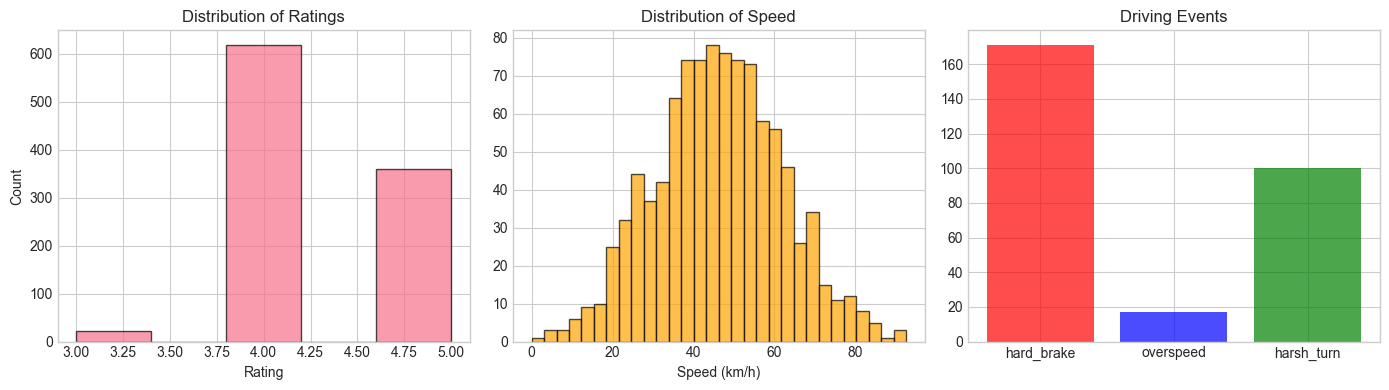

In [6]:
# Quick visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(ratings['rating'], bins=5, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Ratings')

axes[1].hist(telematics['speed'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Speed (km/h)')
axes[1].set_title('Distribution of Speed')

events = ['hard_brake', 'overspeed', 'harsh_turn']
event_counts = [telematics[e].sum() for e in events]
axes[2].bar(events, event_counts, color=['red', 'blue', 'green'], alpha=0.7)
axes[2].set_title('Driving Events')

plt.tight_layout()
plt.show()